# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [3]:
# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

print(train_ds[0])
print(test_ds[0])

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    # max_len = 400  # 입력 문장의 최대 길이 설정
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(
        tokenizer(texts, padding=True).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'label': 2}


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [4]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [5]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')


        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [6]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [7]:
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력

        # 시그모이드는 생략 가능 (BCEWithLogitsLoss를 썼다면 threshold만 적용)
        preds = torch.argmax(preds, dim=-1)
        # preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [8]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

train_accs = []
test_accs = []

# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # 이진 분류용 손실 함수 >> classification 분류용 손실 함수

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 20

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        # inputs, labels = inputs.to('cuda'), labels.to('cuda').float()  # GPU 이동 및 float 변환
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # preds = model(inputs)[..., 0]  # 출력 차원 맞추기 (batch_size,)
        preds = model(inputs)

        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # loss 누적

    with torch.no_grad():
      model.eval()  # 평가 모드로 전환 (계산 비활성화)
      train_accs.append(accuracy(model, train_loader))
      test_accs.append(accuracy(model, test_loader))

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch   0 | Train Loss: 101.25812011957169
Epoch   1 | Train Loss: 69.91924700140953
Epoch   2 | Train Loss: 59.966129153966904
Epoch   3 | Train Loss: 54.08908128738403
Epoch   4 | Train Loss: 51.381760627031326
Epoch   5 | Train Loss: 49.01686280965805
Epoch   6 | Train Loss: 47.8739669919014
Epoch   7 | Train Loss: 46.77365732192993
Epoch   8 | Train Loss: 45.41434846818447
Epoch   9 | Train Loss: 45.02356457710266
Epoch  10 | Train Loss: 43.96321478486061
Epoch  11 | Train Loss: 43.731411427259445
Epoch  12 | Train Loss: 42.89641197025776
Epoch  13 | Train Loss: 42.193721637129784
Epoch  14 | Train Loss: 42.41414752602577
Epoch  15 | Train Loss: 41.45425146818161
Epoch  16 | Train Loss: 41.57609011232853
Epoch  17 | Train Loss: 40.86055278778076
Epoch  18 | Train Loss: 40.78179316222668
Epoch  19 | Train Loss: 40.608363315463066


In [9]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

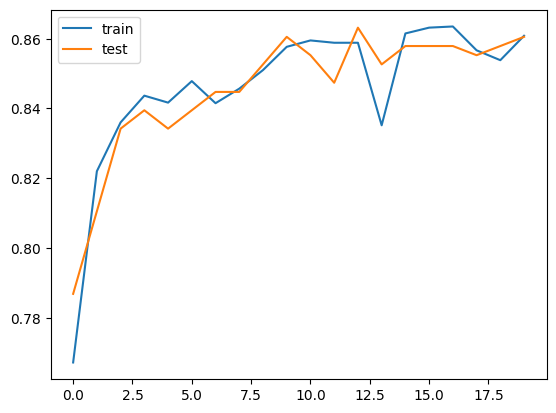

In [10]:
plot_acc(train_accs, test_accs, 'train', 'test')

In [11]:
model.eval()  # 모델을 평가 모드로 설정

with torch.no_grad():  # Gradient 계산 비활성화
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')  # 데이터를 GPU로 이동

        outputs = model(inputs)  # 모델에 입력 데이터를 전달하여 출력 얻기
        predicted_labels = torch.argmax(outputs, dim=1)  # 출력에서 가장 큰 값을 가진 클래스 예측

        # 예측 결과와 실제 라벨 출력 및 비교
        for i in range(len(predicted_labels)):
            predicted_label = predicted_labels[i].item()
            actual_label = labels[i].item()

            # 클래스 이름 가져오기
            predicted_class_name = train_ds.features['label'].names[predicted_label]
            actual_class_name = train_ds.features['label'].names[actual_label]

            print(f"[{ 'SUCCESS' if predicted_label == actual_label else 'FAIL' }]",f"예측: {predicted_label}({predicted_class_name}), 실제: {actual_label}({actual_class_name})")

[SUCCESS] 예측: 2(Business), 실제: 2(Business)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[FAIL] 예측: 2(Business), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[SUCCESS] 예측: 3(Sci/Tech), 실제: 3(Sci/Tech)
[FAIL] 예측: 2(B